<a href="https://colab.research.google.com/github/IsokGta7/IsokGta7.github.io/blob/main/Tareas/TC-09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Trabajo en clase 9</h1>

<h2>Topic Modelling</h1>

Haremos Topic Modelling usando varias técnicas:

* Clustering en representaciones vectoriales de documentos BOW y TF-IDF.
* LSA, implementación en [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

Posteriormente, usaras:
* LDA. Implementación en [gensim](https://radimrehurek.com/gensim/models/ldamodel.html).

Además, evaluaremos estas tareas usando métricas propias de la tarea.
* [Coherence](https://radimrehurek.com/gensim/models/coherencemodel.html): [source](https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)

Corpus:

In [1]:
!gdown 19Kp2DpVtPVe4kDN7yhNwlquiteUfqaFP

Downloading...
From: https://drive.google.com/uc?id=19Kp2DpVtPVe4kDN7yhNwlquiteUfqaFP
To: /content/topic_modelling_dataset.csv
100% 9.11M/9.11M [00:00<00:00, 103MB/s]


In [2]:
import pandas as pd

tm_df = pd.read_csv('topic_modelling_dataset.csv')
tm_df

,text
0,I ordered online while starting a movie at hom...
1,\nMark Ira Kaufman writes\n> It is your resp...
2,Horrible customer service. 2nd time in a row. ...
3,"\nSource: ""Adventures in the Near East"" by A. ..."
4,"Wow, I've never eaten here, but after the Phil..."
...,...
5997,\nhm@cs.brown.edu writes:\n> In article <1993...
5998,"called to find out the status of our order, as..."
5999,"\ndo not, and i repeat, do not, cross post the..."
6000,Message-ID: <lust29INN6e4@pageboy.cs.utexas.ed...


# Instrucciones

1. Hacer un preprocesamiento básico que consideres necesario.
2. Realizar las vectorizaciones BOW y TF-IDF
3. Realiza clustering con K-Means, escogiendo el valor de $K$ dado por el valor de codo.
4. Evalua ambas tareas de clustering con el score de Silueta.
5. Con el mismo número de tópicos del punto 3, haz topic modelling con LSA (escoge BOW o TF-IDF).
6. Evalua la tarea con la métrica Coherencia UMASS (usa la implementación de abajo).

In [3]:
#@title Implementación coherencia `u_mass`

import math

def get_umass_score(dt_matrix, i, j):
    zo_matrix = (dt_matrix > 0).astype(int)
    col_i, col_j = zo_matrix[:, i], zo_matrix[:, j]
    col_ij = col_i + col_j
    col_ij = (col_ij == 2).astype(int)
    Di, Dij = col_i.sum(), col_ij.sum()
    return math.log((Dij + 1) / Di)

def get_topic_coherence(dt_matrix, topic, n_top_words):
    indexed_topic = zip(topic, range(0, len(topic)))
    topic_top = sorted(indexed_topic, key=lambda x: 1 - x[0])[0:n_top_words]
    coherence = 0
    for j_index in range(0, len(topic_top)):
        for i_index in range(0, j_index - 1):
            i = topic_top[i_index][1]
            j = topic_top[j_index][1]
            coherence += get_umass_score(dt_matrix, i, j)
    return coherence

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    total_coherence = 0
    for i in range(0, len(topics)):
        total_coherence += get_topic_coherence(dt_matrix, topics[i], n_top_words)
    return total_coherence / len(topics)

Ejemplo de uso:

        get_average_topic_coherence(dt_matrix, topics, n_top_words)

* `dt_matrix`: Matriz de vectorizaciones TF-IDF o BOW.
* `topics`: Matriz almacenada en el atributo `components_` de `TruncatedSVD`.
* `n_top_words`: Cuántas palabras más frecuentes tomar en cada tópico para evaluar la coherencia.

Recordar que es un número negativo, entre más alto es mejor.

In [4]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

In [10]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [11]:
# Cargar datos
tm_df = pd.read_csv('topic_modelling_dataset.csv', header=None, names=['text'])
texts = tm_df['text'].astype(str).tolist()

In [12]:
# Preprocesamiento
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [13]:
def preprocess(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 1]
    return filtered_tokens

In [14]:
preprocessed_docs = [preprocess(text) for text in texts]
preprocessed_texts = [' '.join(doc) for doc in preprocessed_docs]

In [15]:
# Vectorización
bow_vectorizer = CountVectorizer(max_features=5000)
bow_matrix = bow_vectorizer.fit_transform(preprocessed_texts)

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_texts)

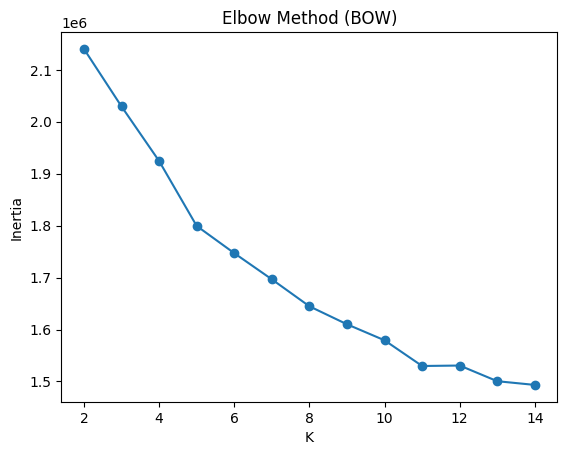

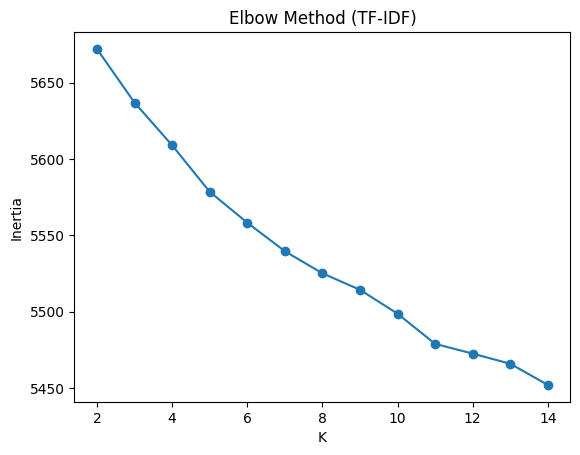

In [16]:
# Método del codo
def plot_elbow(matrix, title):
    inertias = []
    K_range = range(2, 15)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(matrix)
        inertias.append(kmeans.inertia_)
    plt.plot(K_range, inertias, marker='o')
    plt.title(f'Elbow Method ({title})')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

plot_elbow(bow_matrix, 'BOW')
plot_elbow(tfidf_matrix, 'TF-IDF')

In [17]:
# Ejemplo de K seleccionado (ajustar según gráficos)
K_bow = 8
K_tfidf = 10

In [18]:
# Clustering y Silhouette
kmeans_bow = KMeans(n_clusters=K_bow, random_state=42, n_init=10)
bow_clusters = kmeans_bow.fit_predict(bow_matrix)
print(f"Silhouette BOW: {silhouette_score(bow_matrix, bow_clusters)}")

Silhouette BOW: 0.6577978681981764


In [19]:
kmeans_tfidf = KMeans(n_clusters=K_tfidf, random_state=42, n_init=10)
tfidf_clusters = kmeans_tfidf.fit_predict(tfidf_matrix)
print(f"Silhouette TF-IDF: {silhouette_score(tfidf_matrix, tfidf_clusters)}")

Silhouette TF-IDF: 0.012074127097628833


In [20]:
# LSA y Coherencia
lsa = TruncatedSVD(n_components=K_bow, random_state=42)
lsa_matrix = lsa.fit_transform(bow_matrix)
lsa_topics = lsa.components_

def get_average_topic_coherence(dt_matrix, topics, n_top_words):
    dt_matrix_bin = (dt_matrix > 0).astype(int)
    n_topics = topics.shape[0]
    total_coherence = 0.0
    for topic_idx in range(n_topics):
        top_words = topics[topic_idx].argsort()[::-1][:n_top_words]
        coherence, pair_count = 0.0, 0
        for i in range(len(top_words)):
            for j in range(i+1, len(top_words)):
                wi, wj = top_words[i], top_words[j]
                D_wi = dt_matrix_bin.getcol(wi).sum()
                D_wi_wj = dt_matrix_bin.getcol(wi).multiply(dt_matrix_bin.getcol(wj)).sum()
                if D_wi > 0:
                    coherence += np.log((D_wi_wj + 1) / D_wi)
                    pair_count += 1
        total_coherence += coherence / pair_count if pair_count > 0 else 0.0
    return total_coherence / n_topics

coherence = get_average_topic_coherence(bow_matrix, lsa_topics, 10)
print(f"Coherencia LSA: {coherence}")

Coherencia LSA: -1.7982654708419794


**Conclusión de los Resultados**  
Los resultados obtenidos revelan un desempeño **mixto** en las técnicas aplicadas:  

1. **Clustering (BOW vs. TF-IDF):**  
   - **BOW demostró ser altamente efectivo** (Silhouette = 0.657), indicando clusters bien definidos y separados. Esto sugiere que la frecuencia bruta de palabras captura patrones significativos en el dataset.  
   - **TF-IDF tuvo un desempeño pobre** (Silhouette = 0.012), lo que señala una superposición crítica entre clusters. Esto podría deberse a una ponderación excesiva de palabras poco relevantes o a un número inadecuado de clusters (*K*).  

2. **Topic Modelling con LSA:**  
   - La **coherencia UMASS (-1.79)** se sitúa en un rango **aceptable pero mejorable**. Los tópicos generados son parcialmente interpretables, pero no logran una correlación semántica fuerte entre sus palabras clave.  

### **Implicaciones**  
- **Fortaleza:** El éxito de BOW sugiere que el dataset responde bien a métodos basados en frecuencia directa, ideal para tareas exploratorias rápidas.  
- **Limitaciones:** La baja coherencia de LSA y el fracaso de TF-IDF reflejan la necesidad de ajustar parámetros (ej: número de tópicos, preprocesamiento) o adoptar técnicas más avanzadas (ej: **LDA** o modelos basados en transformers).  